In [12]:
%matplotlib inline
%load_ext autoreload
%autoreload 
%load_ext tensorboard  

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [13]:
import tensorflow as tf     
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.python.framework.ops import disable_eager_execution
import matplotlib.colors as mcolors
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sklearn
import tensorflow.keras.backend as kb
import yaml
import datetime
import glob
import numpy as np
import scipy.io as sio
import scipy.interpolate
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import collections
from collections import Counter 

In [14]:
from HelperFn.ExpData_Generator import TrainingGenerator
from HelperFn.ExpData_Generator import EvalTestGenerator
from HelperFn.utils import Params
from sklearn.metrics import r2_score
# from vis.visualization import visualize_saliency, visualize_cam, overlay

In [15]:
# Update MODEL_DIR and mini_EXP_name 
## folder contains: weights, yaml file, and figures

MODEL_DIR = 'Experiments'
mini_EXP_name = 'new_all_combined/architecture4/batch_size128/runs2/run2.3' #output folder where everything will be saved after eval
exp_folder_path = 'Experiments/'+ mini_EXP_name

MODEL_DIR = './Experiments'
DATA_DIR = '../processed_input_data_all/'
NPY_FOLDER = 'slice_npy/'
F_MASTER = 'file_master'
ML_EXP = 'split_master/'
Train_Master = 'train_master.txt'
Eval_Master = 'eval_master.txt'
Test_Master = 'test_master.txt'
json_path = os.path.join(exp_folder_path, 'params.json')
params = Params(json_path)
mini_exp_list= ['new_all_combined/architecture4/batch_size128/runs2/run2.3.3',
                'new_all_combined/architecture4/batch_size128/runs2/run2.3.4',
                'new_all_combined/architecture4/batch_size128/runs2/run2.3.5']
#mini_exp_list=is used for trainning to do many interations to look for the best weight 

In [16]:
with open(exp_folder_path + "/raw_history.yaml", "r") as filehandle:
    raw_history = yaml.load(filehandle, Loader = yaml.Loader)

val_loss = raw_history['val_loss']
train_accuracy = raw_history['custom_accuracy_2SD']
val_accuracy = raw_history['val_custom_accuracy_2SD']
best_model_EPOCH = val_loss.index(min(val_loss)) + 1 
selected_history = {}
selected_history['Bmodel_EPOCH'] = best_model_EPOCH
selected_history['min_val_loss'] =  np.round(min(val_loss),4)
selected_history['max_train_accuracy'] =  np.round(max(train_accuracy),4)
selected_history['max_val_accuracy'] =  np.round(max(val_accuracy),4)
selected_history['Bmodel_train_accuracy'] =  np.round(train_accuracy[val_loss.index(min(val_loss))],4)
selected_history['Bmodel_val_accuracy'] = np.round(val_accuracy[val_loss.index(min(val_loss))],4)

In [17]:
selected_history

{'Bmodel_EPOCH': 34,
 'min_val_loss': 0.0643,
 'max_train_accuracy': 0.8336,
 'max_val_accuracy': 0.8624,
 'Bmodel_train_accuracy': 0.8224,
 'Bmodel_val_accuracy': 0.8624}

In [18]:
def Plot_Loss(mini_exp_list, selected_exp,final_EPOCH, 
              l_width, l_alpha, marker_size, fig_size):
    
    ### Part 1: plot of the selected exp in solid 
    
    ##extract full raw history from selected experiments 
    selected_exp_path = MODEL_DIR + '/' + selected_exp
    with open(selected_exp_path + "/raw_history.yaml", "r") as filehandle2:
            raw_history = yaml.load(filehandle2, Loader = yaml.Loader)
    
    train_loss = raw_history['loss']
    val_loss = raw_history['val_loss']
    
    
    ## plot train loss
    plt.plot(train_loss, color = 'dodgerblue', 
                 linewidth=l_width*2, 
                 alpha=l_alpha*2, label = 'Train_Loss (best model)')
    
    ## plot eval loss
    
    #Extract saved_bmodel from one selected experiment
    saved_bmodel = glob.glob(selected_exp_path + '/*.hdf5',  
           recursive = True)  
    b_ep_list =[]
    for file in saved_bmodel: 
        b_ep_list.append(np.int(file.split('-')[-2][0:2])-1)
        sorted_b_ep_list = sorted(b_ep_list)
        b_ep_list = sorted_b_ep_list
    Val_Loss_list = list(val_loss[i] for i in b_ep_list)       
    plt.plot(b_ep_list,Val_Loss_list, color = 'coral', 
                 marker='o', markersize=marker_size*2.5, 
                 linewidth=l_width*2, linestyle='solid', 
                 alpha=l_alpha*2, label = 'Eval_Loss (best model)')
    plt.plot(val_loss,color = 'coral', 
                 linestyle='dashed', linewidth=l_width*1.5, 
                 alpha=l_alpha)


    ### Part 2: plot all exp in transparants  
    
    ##extract full raw history from all experiments
    for m_idx, m in enumerate(mini_exp_list):
        exp_folder_path = MODEL_DIR + '/' + m
        #print(exp_folder_path)
        with open(exp_folder_path + "/raw_history.yaml", "r") as filehandle2:
            raw_history = yaml.load(filehandle2, Loader = yaml.Loader)
        train_loss = raw_history['loss']
        val_loss = raw_history['val_loss']
        
        #Extract saved_bmodel to highlight the improved loss
        saved_bmodel = glob.glob(exp_folder_path + '/*.hdf5',  
           recursive = True)
        b_ep_list =[]
        for file in saved_bmodel: 
            b_ep_list.append(np.int(file.split('-')[-2][0:2])-1)
            sorted_b_ep_list = sorted(b_ep_list)
            b_ep_list = sorted_b_ep_list
                    
        Val_Loss_list = list(val_loss[i] for i in b_ep_list)
        
        if m_idx == 0:
            train_label = 'Train_Loss (repeated runs)'
            eval_label = 'Eval_Loss (repeated runs)'
        else:
            train_label = None
            eval_label = None
        
        #plot all train loss
        plt.plot(train_loss, color = 'dodgerblue', 
                 linewidth=l_width, 
                 alpha=l_alpha*0.25, label = train_label)
        
        #plot saved models with markers 
        plt.plot(b_ep_list,Val_Loss_list, color = 'coral',
                 marker ='o', markersize=marker_size*0.5,
                 linewidth=l_width, linestyle='solid', 
                 alpha=l_alpha, label = eval_label)
        #plot all eval loss with dashed lines
        plt.plot(val_loss,color = 'coral', 
                 linestyle='dashed', linewidth=l_width, 
                 alpha=l_alpha*0.25)
        
        
#   plt.title(str(keyword), fontsize = 20)
    plt.rcParams["font.family"] = 'Helvetica'
    plt.ylabel('Loss',fontsize = 16)
    plt.xlabel('Epoch', fontsize = 16)
    plt.xlim([0,34])
    plt.ylim([0,1.0])
    lgnd = plt.legend(loc='upper right',fontsize = 12)
    #lgnd.legendHandles[1]._legmarker.set_markersize(10)
    
    #lgnd.legendHandles[1]._legmarker.set_markersize(10)
    plt.savefig('Loss_All.svg', dpi=900, edgecolor='w',
        orientation='portrait', format='svg',
        transparent=False, bbox_inches=None, pad_inches=0.1)
    
    plt.savefig('Loss_All.jpeg', dpi=900, edgecolor='w',
        orientation='portrait', format='jpeg',
        transparent=False, bbox_inches=None, pad_inches=0.1)

/var/folders/jj/d2b55p793xx14k8bbf2nltym0000gs/T/ipykernel_48298/3260327819.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b_ep_list.append(np.int(file.split('-')[-2][0:2])-1)
/var/folders/jj/d2b55p793xx14k8bbf2nltym0000gs/T/ipykernel_48298/3260327819.py:56: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish t

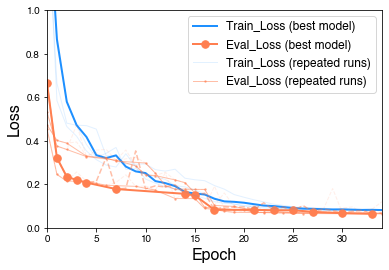

In [19]:

Plot_Loss(mini_exp_list, selected_exp = mini_EXP_name ,final_EPOCH = 34, l_width = 1, l_alpha = 0.5, marker_size = 3, fig_size =(10,10))

In [20]:
def Plot_Accuracy(mini_exp_list, selected_exp,final_EPOCH, 
              l_width, l_alpha, marker_size, fig_size):
    
    ### Part 1: plot of the selected exp in solid 
    
    ##extract full raw history from selected experiments 
    selected_exp_path = MODEL_DIR + '/' + selected_exp
    with open(selected_exp_path + "/raw_history.yaml", "r") as filehandle2:
            raw_history = yaml.load(filehandle2, Loader = yaml.Loader)
    
    train_acc = raw_history['custom_accuracy_2SD']
    val_acc = raw_history['val_custom_accuracy_2SD']*100
    
    
    ## plot train acc
    plt.plot(train_acc, color = 'dodgerblue', 
                 linewidth=l_width*2, 
                 alpha=l_alpha*2, label = 'Train_Accuracy (best model)')
    
    ## plot eval acc
    
    #Extract saved_bmodel from one selected experiment
    saved_bmodel = glob.glob(selected_exp_path + '/*.hdf5',  
           recursive = True)  
    b_ep_list =[]
    for file in saved_bmodel: 
        b_ep_list.append(np.int(file.split('-')[-2][0:2])-1)
        sorted_b_ep_list = sorted(b_ep_list)
        b_ep_list = sorted_b_ep_list
    Val_Acc_list = list(val_acc[i] for i in b_ep_list)       
    plt.plot(b_ep_list,Val_Acc_list, color = 'coral', 
                 marker='o', markersize=marker_size*2.5, 
                 linewidth=l_width*2, linestyle='solid', 
                 alpha=l_alpha*2, label = 'Eval_Accuracy (best model)')
    plt.plot(val_acc,color = 'coral', 
                 linestyle='dashed', linewidth=l_width*1.5, 
                 alpha=l_alpha)

    ### Part 2: plot all exp in transparants  
    
    ##extract full raw history from all experiments
    for m_idx, m in enumerate(mini_exp_list):
        exp_folder_path = MODEL_DIR + '/' + m
        with open(exp_folder_path + "/raw_history.yaml", "r") as filehandle2:
            raw_history = yaml.load(filehandle2, Loader = yaml.Loader)
        train_acc = raw_history['custom_accuracy_2SD']*100
        val_acc = raw_history['val_custom_accuracy_2SD']*100
        
        #Extract saved_bmodel to highlight the improved acc
        saved_bmodel = glob.glob(exp_folder_path + '/*.hdf5',  
           recursive = True)
        b_ep_list =[]
        for file in saved_bmodel: 
            b_ep_list.append(np.int(file.split('-')[-2][0:2])-1)
            sorted_b_ep_list = sorted(b_ep_list)
            b_ep_list = sorted_b_ep_list
                    
        Val_Acc_list = list(val_acc[i] for i in b_ep_list)
        
        
        if m_idx == 0:
            train_label = 'Train_Accuracy (repeated runs)'
            eval_label = 'Eval_Accuracy (repeated runs)'
        else:
            train_label = None
            eval_label = None
        
        
        #plot all train loss
        plt.plot(train_acc, color = 'dodgerblue', 
                 linewidth=l_width, 
                 alpha=l_alpha*0.25, label = train_label)
        
        #plot saved models with markers 
        plt.plot(b_ep_list,Val_Acc_list, color = 'coral', 
                 marker='o', markersize=marker_size*0.5, 
                 linewidth=l_width, linestyle='solid', 
                 alpha=l_alpha*0.25, label = eval_label)
        #plot all eval loss with dashed lines
        plt.plot(val_acc,color = 'coral', 
                 linestyle='dashed', linewidth=l_width, 
                 alpha=l_alpha*0.25)
    
    plt.rcParams["font.family"] = 'Helvetica'
    plt.ylabel('Accuracy ',fontsize = 16)
    plt.xlabel('Epoch', fontsize = 16)
    plt.xlim([0,34])
    plt.ylim([0,1])
    
    lgnd = plt.legend(loc='lower right',fontsize = 12)
#    lgnd.legendHandles[1]._legmarker.set_markersize(10)
    plt.savefig('Acc_All.svg', dpi=900, edgecolor='w',
        orientation='portrait', format='svg',
        transparent=False, bbox_inches=None, pad_inches=0.1)
    
    plt.savefig('Acc_All.jpeg', dpi=900, edgecolor='w',
        orientation='portrait', format='jpeg',
        transparent=False, bbox_inches=None, pad_inches=0.1)

/var/folders/jj/d2b55p793xx14k8bbf2nltym0000gs/T/ipykernel_48298/2389744671.py:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  b_ep_list.append(np.int(file.split('-')[-2][0:2])-1)
/var/folders/jj/d2b55p793xx14k8bbf2nltym0000gs/T/ipykernel_48298/2389744671.py:54: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish t

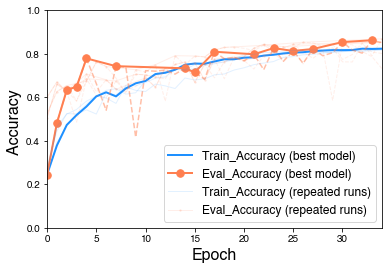

In [21]:
Plot_Accuracy(mini_exp_list, selected_exp = mini_EXP_name ,final_EPOCH = 34, l_width = 1, l_alpha = 0.5, marker_size = 3, fig_size =(10,10))

In [61]:
def MSE_wSD_loss(Y_true, KE_pred):
    KE_true = Y_true[:, 0]
    SD_true = Y_true[:, 1]
    mse = tf.keras.losses.MeanSquaredError()
    return mse(Y_true[:, 0], KE_pred)/((Y_true[:, 1])**1+1e-5)

def custom_accuracy_2SD(Y_true, KE_pred):
    KE_true = Y_true[:, 0]
    SD_true = Y_true[:, 1]
    KE_pred = KE_pred[:, 0]
    C_accuracy = kb.mean(kb.cast(kb.less_equal(kb.abs(KE_pred-KE_true),1*SD_true), dtype = "float32"))
    return C_accuracy 

def custom_accuracy_SD(Y_true, KE_pred):
    KE_true = Y_true[:, 0]
    SD_true = Y_true[:, 1]
    KE_pred = KE_pred[:, 0]
    C_accuracy = kb.mean(kb.cast(kb.less_equal(kb.abs(KE_pred-KE_true),SD_true), dtype = "float32"))
    return C_accuracy 

def custom_accuracy_avSD(Y_true, KE_pred):
    KE_true = Y_true[:, 0]
    SD_true = Y_true[:, 1]
    KE_pred = KE_pred[:, 0]
    C_accuracy = kb.mean(kb.cast(kb.less_equal(kb.abs(KE_pred-KE_true),0.08), dtype = "float32"))
    return C_accuracy 

def custom_accuracy_mostSD(Y_true, KE_pred):
    KE_true = Y_true[:, 0]
    SD_true = Y_true[:, 1]
    KE_pred = KE_pred[:, 0]
    C_accuracy = kb.mean(kb.cast(kb.less_equal(kb.abs(KE_pred-KE_true),0.2), dtype = "float32"))
    return C_accuracy 

In [62]:
mini_e = mini_EXP_name
exp_folder_path = MODEL_DIR + '/' + mini_e
files = glob.glob(exp_folder_path + '/*.hdf5',  
                   recursive = True)
saved_model = []
for file in files:
    print(file.split('/')[-1])
    saved_model.append(file.split('/')[-1])

weights-improvement-25-0.83.hdf5
weights-improvement-10-0.82.hdf5
weights-improvement-06-0.78.hdf5
weights-improvement-01-0.12.hdf5
weights-improvement-28-0.85.hdf5
weights-improvement-05-0.62.hdf5
weights-improvement-08-0.81.hdf5
weights-improvement-34-0.84.hdf5
weights-improvement-03-0.59.hdf5
weights-improvement-12-0.83.hdf5
weights-improvement-02-0.42.hdf5


In [63]:
selectedE = 34
selected_weights = ''
for file in saved_model:
    if file.split('-')[-2][0:2]==str(selectedE):
        selected_weights = file
print (selected_weights)  

weights-improvement-34-0.84.hdf5


In [64]:
filepath = exp_folder_path + '/' +selected_weights 
best_model = tf.keras.models.load_model(filepath, custom_objects = 
                                        {"MSE_wSD_loss":MSE_wSD_loss, 
                                "custom_accuracy_2SD": custom_accuracy_2SD,
                                "custom_accuracy_SD": custom_accuracy_SD,
                                "custom_accuracy_avSD": custom_accuracy_avSD})

In [65]:
input_slice_shape = (128,64,1)
batch_size = 128 #params.batch_size
MMT = 0.95 #params.bn_momentum
LR = 3e-3 #params.learning_rate
num_channels = params.num_channels
#EPOCH = params.num_epochs

In [66]:
#apply best model to three subset of data
batch_size = 1 
##Training
train_generator = EvalTestGenerator(ML_EXP, NPY_FOLDER, Train_Master, 
                                       batch_size = batch_size, 
                                       data_dir=DATA_DIR, shuffle = False)
train_label = np.hstack([batch[1][:,0] for batch in train_generator])
train_SD = np.hstack([batch[1][:,1] for batch in train_generator])
train_pred = best_model.predict(x=train_generator)

##Validation
eval_generator = EvalTestGenerator(ML_EXP, NPY_FOLDER, Eval_Master, 
                                         batch_size = batch_size, 
                                         data_dir=DATA_DIR, shuffle = False)
eval_label = np.hstack([batch[1][:,0] for batch in eval_generator])
eval_SD = np.hstack([batch[1][:,1] for batch in eval_generator])
eval_pred = best_model.predict(x=eval_generator)

##Testing
test_generator = EvalTestGenerator(ML_EXP, NPY_FOLDER, Test_Master, 
                                   batch_size = batch_size, 
                                   data_dir=DATA_DIR, shuffle = False)
test_label = np.hstack([batch[1][:,0] for batch in test_generator])
test_SD = np.hstack([batch[1][:,1] for batch in test_generator])
test_pred = best_model.predict(x=test_generator)

4840
4840
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1201
1201
701
701


In [67]:
train_LSP = [train_label,train_SD,train_pred]
eval_LSP = [eval_label,eval_SD,eval_pred]
test_LSP = [test_label,test_SD,test_pred]
generator_LSP = [train_LSP,eval_LSP,test_LSP]

In [68]:
def plotting_with_TS(LSP, mode):
    ## make cross plot between prediction and label with highlighted color for subset that meet threashold
    label = LSP[0]
    SD = LSP[1]
    pred = LSP[2].flatten()
    idx = np.abs(pred-label) > 1*SD
    error_pct = np.round(100*np.sum(idx)/len(pred), 1)
    text_accuracy = str(100 - error_pct) + '%'
    
    fig, ax = plt.subplots(figsize=(6,6), dpi=900) 
    
    ax.plot(pred, label,'bo',alpha=0.15, label=f'Correct   ' +  str(100 - error_pct) + '%') 
    ax.plot(pred[idx], label[idx], 'ro',alpha=0.15, label=f'Incorrect   ' + str(error_pct) + '%') 
    ax.plot([0,1], [0,1], 'k',alpha=0.5, linewidth=0.5)
    ax.set_title(str(mode), fontsize = 24)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
#     ax.text(0.3, 0.85, text_error, fontsize = 12, style = 'italic', weight='normal',
#             horizontalalignment = 'center',transform=ax.transAxes)
    ax.set_ylabel('Experimental Value', fontsize =20)
    ax.set_xlabel('CNN Prediction', fontsize = 20)
    lgnd = ax.legend(loc='upper left',prop={'size': 16} )
   # lgnd.legendHandles[0]._legmarker.set_markersize(18)
   # lgnd.legendHandles[1]._legmarker.set_markersize(18)
    plt.savefig(str(mode)  + 'evaluate_result1.svg', dpi=900, edgecolor='w',
        orientation='portrait', format='svg',
        transparent=False, bbox_inches=None, pad_inches=0.1)
    
    plt.savefig(str(mode)  + 'evaluate_result1.jpeg', dpi=900, edgecolor='w',
        orientation='portrait', format='jpeg',
        transparent=False, bbox_inches=None, pad_inches=0.1)
    
    plt.tight_layout()
    plt.show

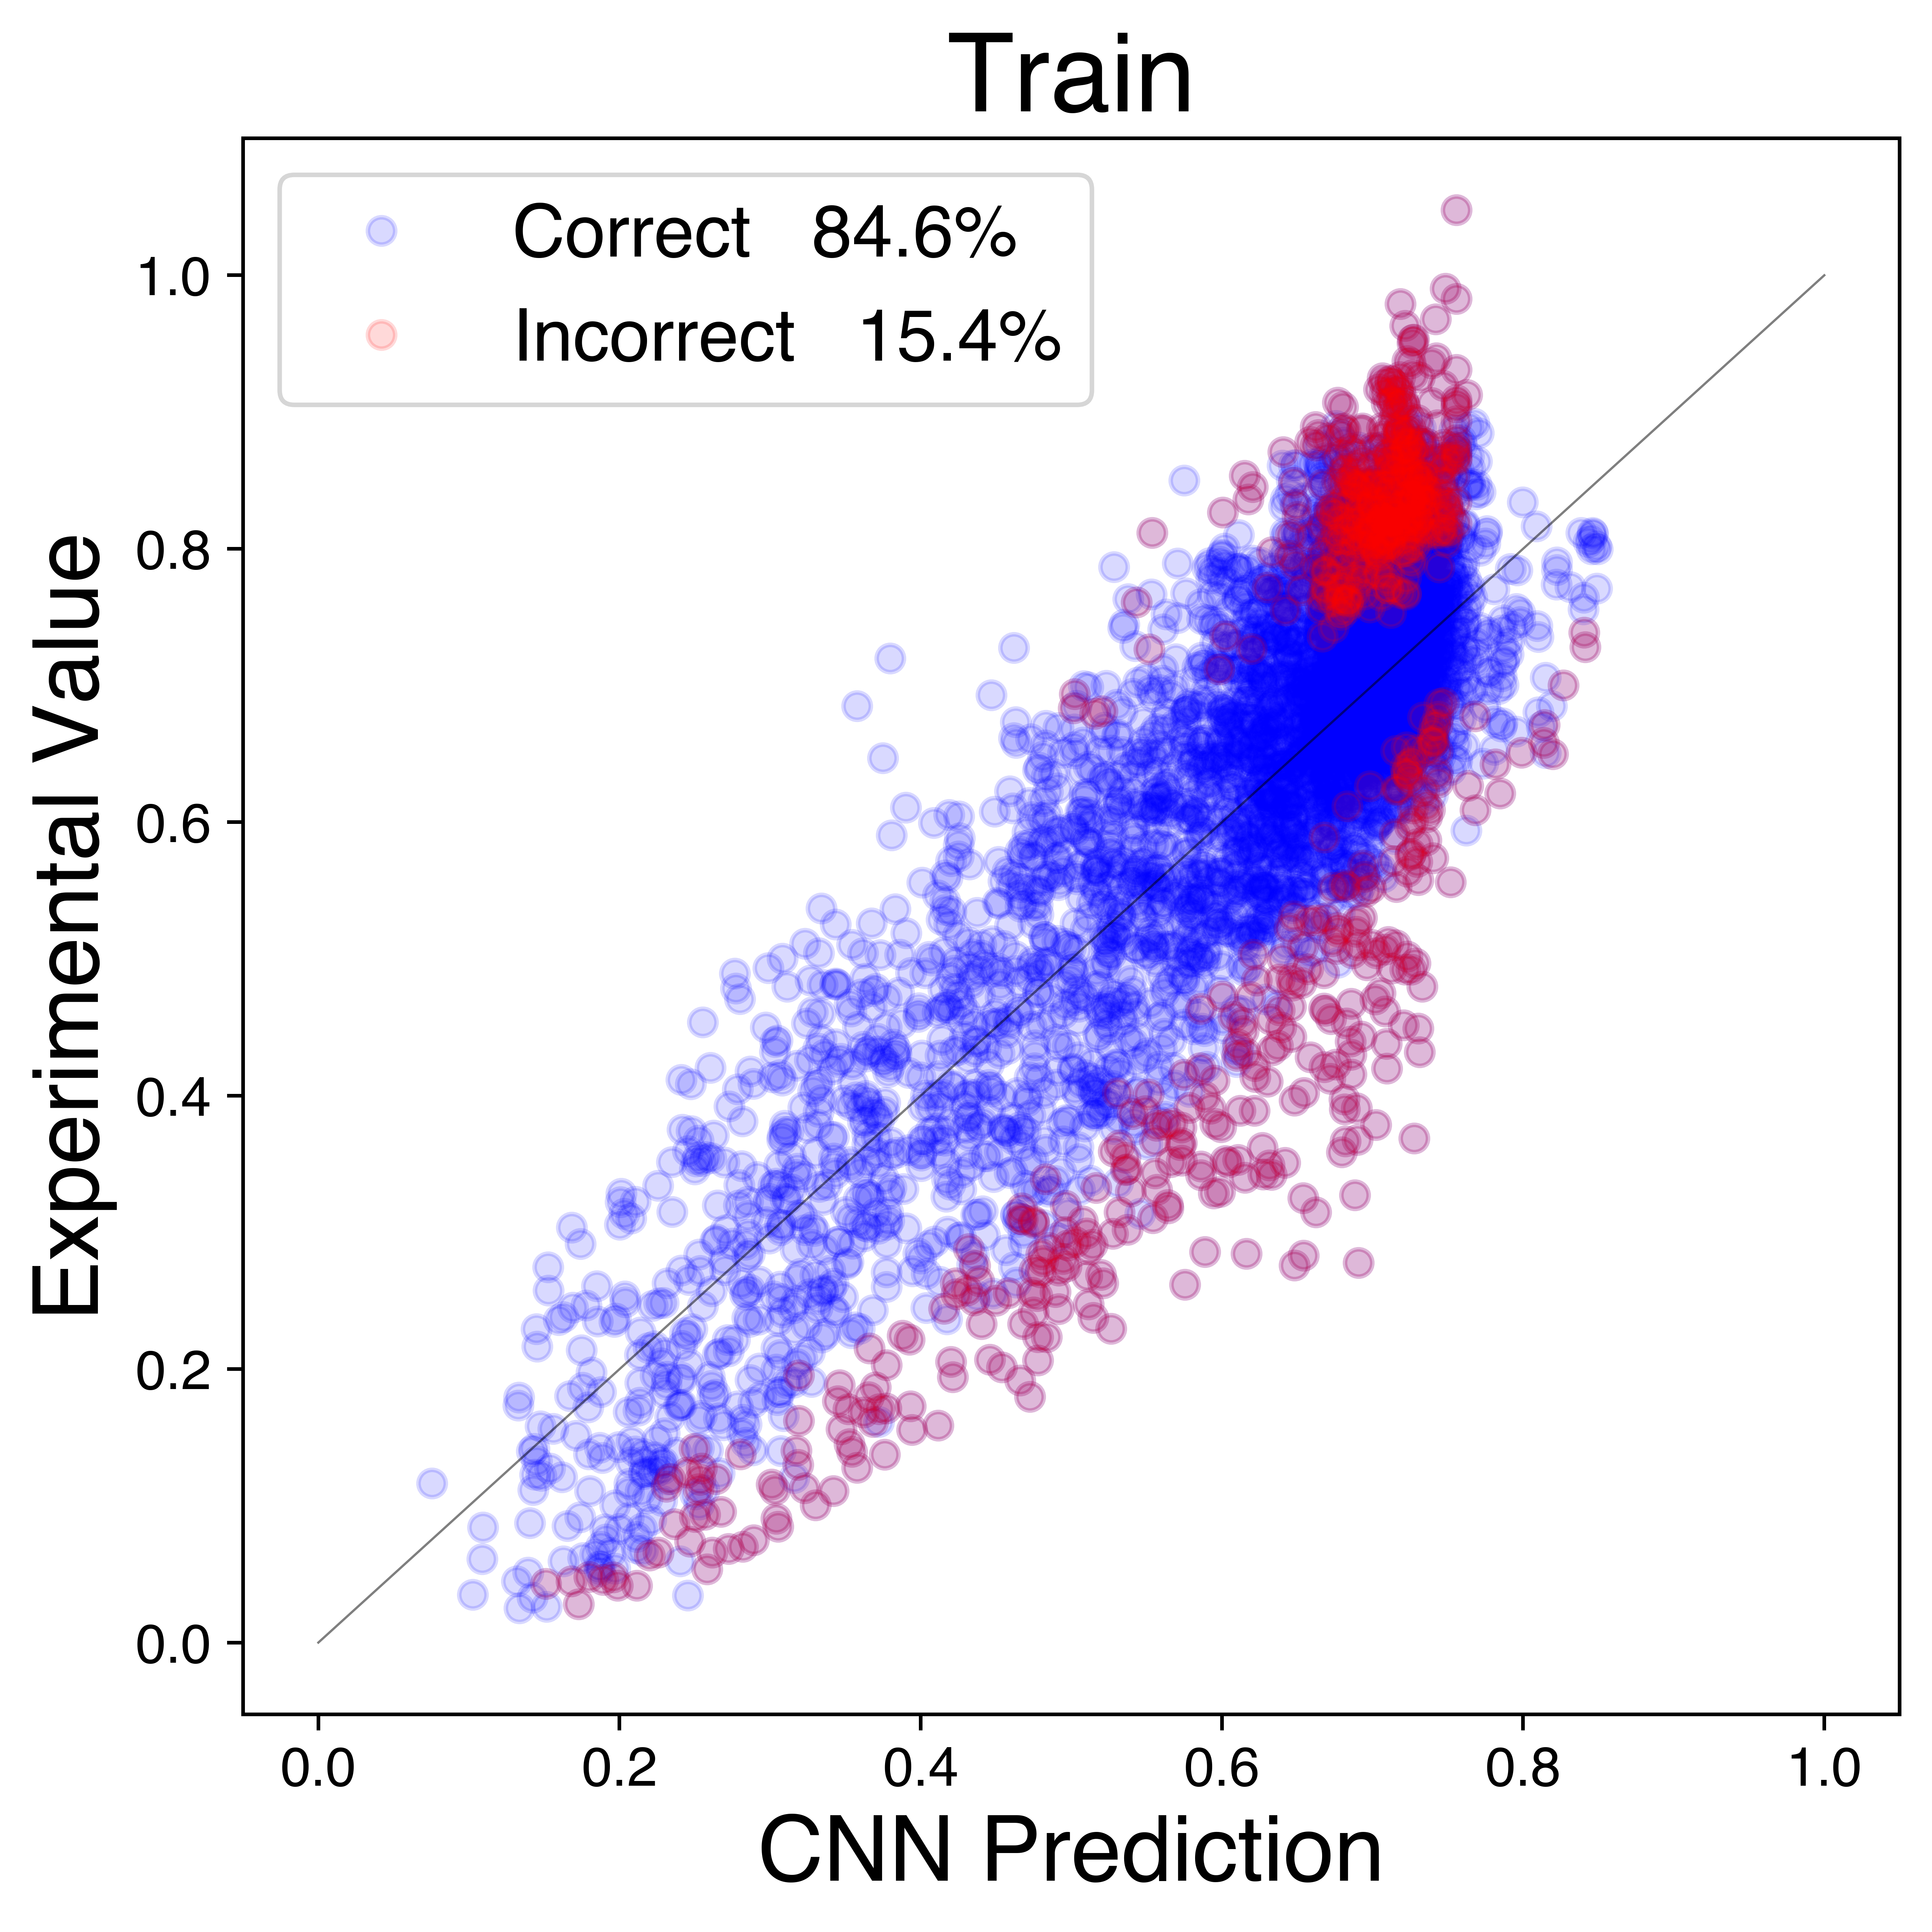

In [69]:
plotting_with_TS(train_LSP, 'Train')

In [70]:
def plotting_with_TS_V(generator_LSP, mode, EXP, selected_EP):
    ## make cross plot between prediction and label with highlighted color for subset that meet threashold
    
    fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(5,12))

    for g, m, ax in zip(generator_LSP, mode, axs): 
        label = g[0]
        SD = g[1]
        pred = g[2].flatten()
#         if len(pred) == len(label):
#             print(len(pred))
        idx = np.abs(pred-label) > 1*SD
        error_pct = np.round(100*np.sum(idx)/len(pred), 1)
        
        correct= 100 - error_pct
        incorrect = error_pct       
        ax.plot(pred, label,'b.',alpha=0.1, label=f'Correct ' + str('{:.1f}'.format(correct))+ '%')
        ax.plot(pred[idx], label[idx], 'r.',alpha=0.1, label=f'Incorrect ' + str('{:.1f}'.format(incorrect))+ '%')
        ax.plot([0, 1], [0, 1], 'k',alpha=0.5)
        ax.set_title(str(m), fontsize = 24)
       # text_error = '% error (>1SD) = ' +str(error_pct) + '%'
       # ax.text(0.7, 0.1, text_error, fontsize = 18,
       #         horizontalalignment = 'center', transform=ax.transAxes)
        ax.legend(loc='upper left')
        ax.set_ylabel('Experimental Value', fontsize =16)
    axs[2].set_xlabel('CNN Prediction', fontsize = 16)

    plt.tight_layout()
    plt.show
    plt.savefig(exp_folder_path  +'/evaluate_results_.jpeg', dpi=900)
    plt.savefig(exp_folder_path  +'/evaluate_results_.svg', dpi=900)

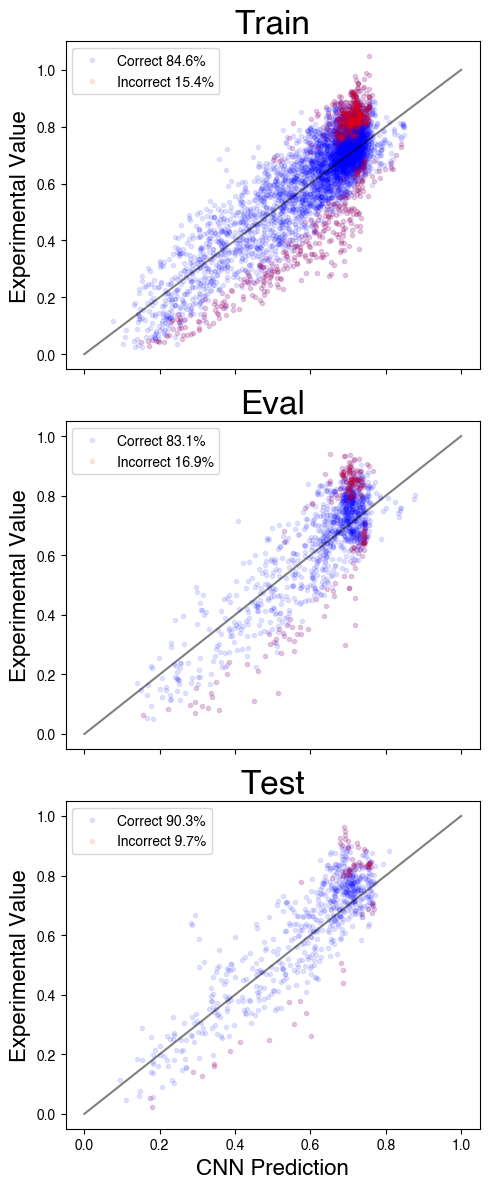

In [71]:
plotting_with_TS_V(generator_LSP, ['Train', 'Eval', 'Test'], EXP = 7.2, selected_EP = selectedE)

In [48]:
def plotting_with_TS_H(generator_LSP, mode, EXP, selected_EP):
    ## make cross plot between prediction and label with highlighted color for subset that meet threashold
    
    fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15, 5))

    for g, m, ax in zip(generator_LSP, mode, axs): 
        label = g[0]
        SD = g[1]
        pred = g[2].flatten()
        if len(pred) == len(label):
            print(len(pred))
        idx = np.abs(pred-label) > 1*SD
        error_pct = np.round(100*np.sum(idx)/len(pred), 2)
        

        ax.plot(pred, label,'b.',alpha=0.25, label=f'Correct')
        ax.plot(pred[idx], label[idx], 'r.',alpha=0.25, label=f'Incorrect')
        ax.plot([0, 1], [0, 1], 'k',alpha=0.4)
        ax.set_title(str(m), fontsize = 24)
        text_error = '% error (>1SD) = ' +str(error_pct) + '%'
        ax.text(0.7, 0.1, text_error, fontsize = 14,
                horizontalalignment = 'center', transform=ax.transAxes)
        ax.legend(loc='best')
        ax.set_xlabel('Prediction', fontsize =18)
    axs[0].set_ylabel('Truth', fontsize = 18)

    plt.tight_layout()
    plt.show

6763
1525
762


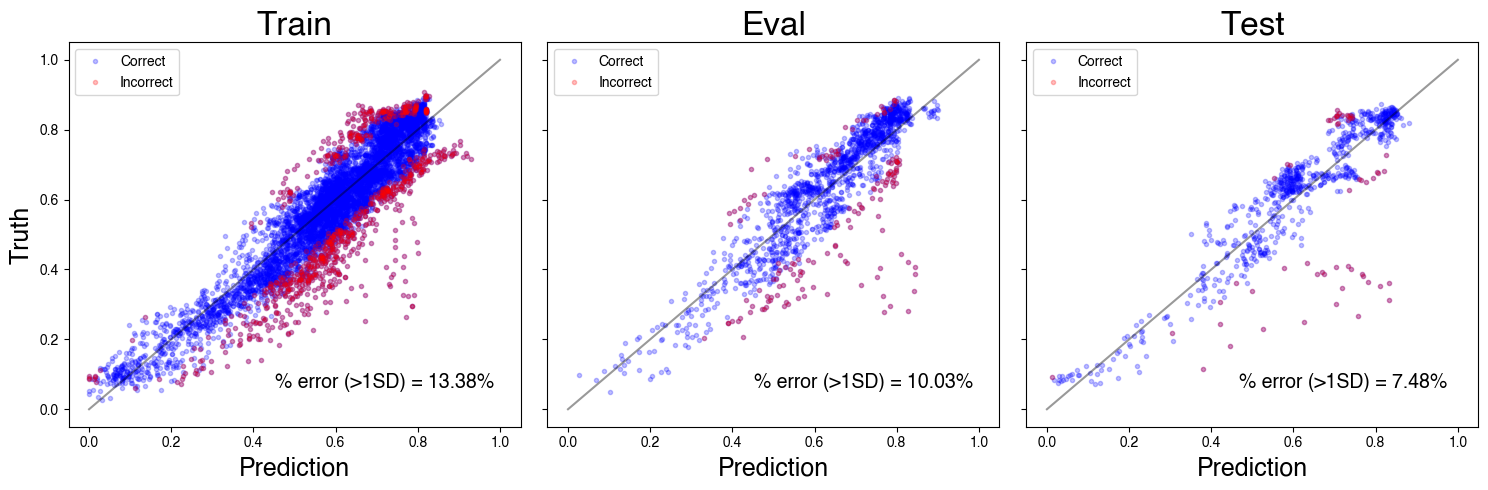

In [49]:
plotting_with_TS_H(generator_LSP, ['Train', 'Eval', 'Test'], EXP = 7.2, selected_EP = selectedE)

In [50]:
def plotting_all_scaled(generator_LSP, mode, EXP, selected_EP):
    ## make cross plot between prediction and label with highlighted color for subset that meet threashold
    
    fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15, 5))

    for g, m, ax in zip(generator_LSP, mode, axs): 
        label = g[0]
        SD = g[1]
        pred = g[2].flatten()
        if len(pred) == len(label):
            print(len(pred))
        idx = np.abs(pred-label) > 1*SD
        error_pct = np.round(100*np.sum(idx)/len(pred), 2)

        repeats_all = list(zip(label, pred))
        weight_counter_all = Counter(repeats_all)
        weights_all = [weight_counter_all[(label[i], pred[i])] for i, _ in enumerate(label)]

        
        repeats = list(zip(label[idx], pred[idx]))
        weight_counter = Counter(repeats)
        weights = [weight_counter[(label[idx][i], pred[idx][i])] for i, _ in enumerate(label[idx])]
 

        ax.set_title(str(m), fontsize = 24)
        ax.scatter(pred, label, s=weights_all, c = 'blue', label=f'Correct')
#         ax.plot(pred, label,'bx',alpha=0.25, label=f'Correct')
#         ax.plot(pred[idx], label[idx], 'rx',alpha=0.25, label=f'Incorrect')
        ax.scatter(pred[idx], label[idx], s=weights, c = 'red', label=f'InCorrect')


        ax.plot([0, 1], [0, 1], 'k',alpha=0.8)
        text_error = '% error (>1SD) = ' +str(error_pct) + '%'
        ax.text(0.7, 0.1, text_error, fontsize = 14,
                horizontalalignment = 'center', transform=ax.transAxes)
        ax.legend(loc='best')
        ax.set_xlabel('Prediction', fontsize =18)
        print('max_repeat: ' + str(np.max(weights)) +'/' +str(len(label)))
    axs[0].set_ylabel('Truth', fontsize = 18)

    plt.tight_layout()
    plt.show

6763
max_repeat: 2/6763
1525
max_repeat: 1/1525
762
max_repeat: 1/762


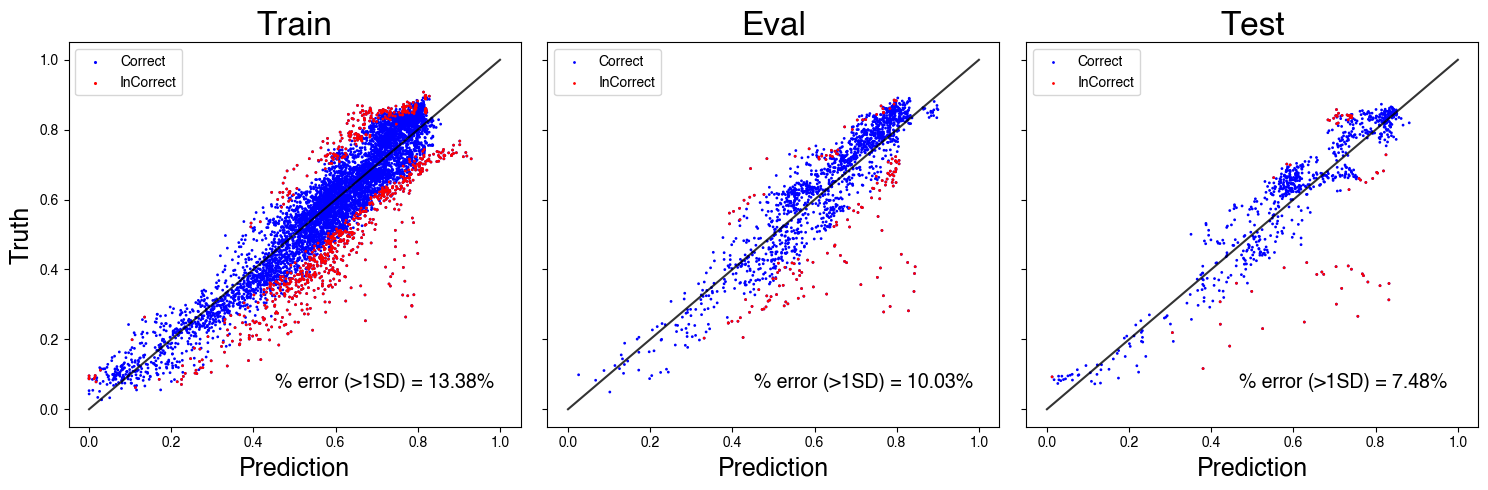

In [51]:
plotting_all_scaled(generator_LSP, ['Train', 'Eval', 'Test'], EXP = 7.2, selected_EP = selectedE)

In [197]:
def plotting_EXP(generator, pred, label, SD, mode, top_ith, num_sample):
      ## selecting outliers 
    y= pred.flatten()
    x= label
    if len(x) == len(y):
        print('size_data_all:',len(x))
    #idx = np.abs(x-y) > 1*SD
    idx=np.logical_and(np.abs(y-x) > 1*SD, x<0.6)
    print('size_data_meetTS:', np.sum(idx))
    print('custom_2SD_Accuracy',(1-np.sum(idx)/len(x))*100, '%' )
    
  
    pred_outlier = np.round(y[idx],2)
    truth_outlier =np.round(x[idx],2)
    diff = np.round(np.abs(pred_outlier - truth_outlier),2)

        ##indexing from large to small for outlier 
    outlier_idx = np.argsort(diff)[::-1]
    y_outlier = pred_outlier[outlier_idx]
    x_outlier = truth_outlier[outlier_idx]
    offset_outlier = np.round(x_outlier-y_outlier,2)
        ## print top rank (num_sample) by the size of errors
    print('pred_outlier: ', y_outlier[top_ith:top_ith+num_sample])
    print('truth_outlier: ', x_outlier[top_ith:top_ith+num_sample])
    
    ##creating fault map of those outliers 
    CMAP = plt.cm.binary
    minCMAP = 0
    maxCMAP = 1
    ncols = num_sample
    print('Top_nth_Outier > 1SD: ', top_ith, '-', top_ith+ncols)
    fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=(20,10))
    norm = mpl.colors.Normalize(vmin=minCMAP, vmax=maxCMAP) 
    mappable = plt.cm.ScalarMappable(norm=norm, cmap=CMAP)
#     cbar = fig.colorbar(mappable, ax = axs.ravel().tolist(), 
#                     orientation='horizontal', fraction=0.05)
#     cbar.ax.tick_params(axis='x', labelsize=20)
    for i in range(ncols):
        filename = generator.filenames[:len(pred)][idx][outlier_idx][top_ith:top_ith+ncols][i]
        print(filename)
        fig_title = (filename[0:24])
        print(fig_title)
        data = np.load(DATA_DIR + NPY_FOLDER + filename)
        prediction = y_outlier[top_ith:top_ith+ncols]
        label = x_outlier[top_ith:top_ith+ncols]
        offset = offset_outlier[top_ith:top_ith+ncols]
        two_SD = 1*SD[idx][outlier_idx][top_ith:top_ith+ncols]
        result = np.abs(offset) < np.round(1*SD[idx][outlier_idx][top_ith:top_ith+ncols],2)
        EXP = str(filename[0:8]) + '/w'+ str(filename[22:30])
        
        FontSize = 30
        
        text_label = axs[i].text(30,20, 'Label: ' 
                                     + str(label[i]), 
                                     fontsize =16, 
                                     ha="center", va="bottom")
        text_prediction = axs[i].text(30,30, 'Pred: ' + str(prediction[i]), 
                                      fontsize =16,
                                      ha="center", va="bottom")
        text_2SD = axs[i].text(30,40, '1SD: ' + str(two_SD[i]), 
                                      fontsize =16,
                                       ha="center", va="bottom")

        if result[i] == True:
            text_result = axs[i].text(30,90, 'Diff: |'  + str(offset[i]) + '|' , 
                                fontsize =16, ha="center", 
                                      va="center", color="b")
        else:
            text_result = axs[i].text(30,90, 'Diff: |'  + str(offset[i]) + '|' ,
                               fontsize =16, ha="center", 
                                     va="center", color="r")
        axs[i].imshow(data, norm=norm, aspect=1, cmap=CMAP)
        axs[i].set_xticklabels( () )
        axs[i].set_yticklabels( () )
        #plt.savefig(MODEL_DIR + '_outlier1.png')

size_data_all: 743
size_data_meetTS: 30
custom_2SD_Accuracy 95.96231493943472 %
pred_outlier:  [0.7  0.7  0.39 0.73 0.4  0.71 0.44 0.72 0.41 0.33]
truth_outlier:  [0.45 0.47 0.17 0.51 0.2  0.51 0.25 0.53 0.23 0.15]
Top_nth_Outier > 1SD:  0 - 10
E444_64px_w_CNN/0.4515_0.0959_win_07_t_036_E444_64px_w_CNN_cfuv.npy
E444_64px_w_CNN/0.4515_0
E444_64px_w_CNN/0.4717_0.1113_win_07_t_042_E444_64px_w_CNN_cfuv.npy
E444_64px_w_CNN/0.4717_0
E350_64px_w_CNN/0.1655_0.1249_win_07_t_006_E350_64px_w_CNN_cfuv.npy
E350_64px_w_CNN/0.1655_0
E444_64px_w_CNN/0.5135_0.0836_win_07_t_035_E444_64px_w_CNN_cfuv.npy
E444_64px_w_CNN/0.5135_0
E481_64px_w_CNN/0.2013_0.1221_win_05_t_015_E481_64px_w_CNN_cfuv.npy
E481_64px_w_CNN/0.2013_0
E444_64px_w_CNN/0.5113_0.1023_win_07_t_047_E444_64px_w_CNN_cfuv.npy
E444_64px_w_CNN/0.5113_0
E481_64px_w_CNN/0.2472_0.1332_win_05_t_016_E481_64px_w_CNN_cfuv.npy
E481_64px_w_CNN/0.2472_0
E444_64px_w_CNN/0.5299_0.1117_win_07_t_044_E444_64px_w_CNN_cfuv.npy
E444_64px_w_CNN/0.5299_0
E494_64px_w

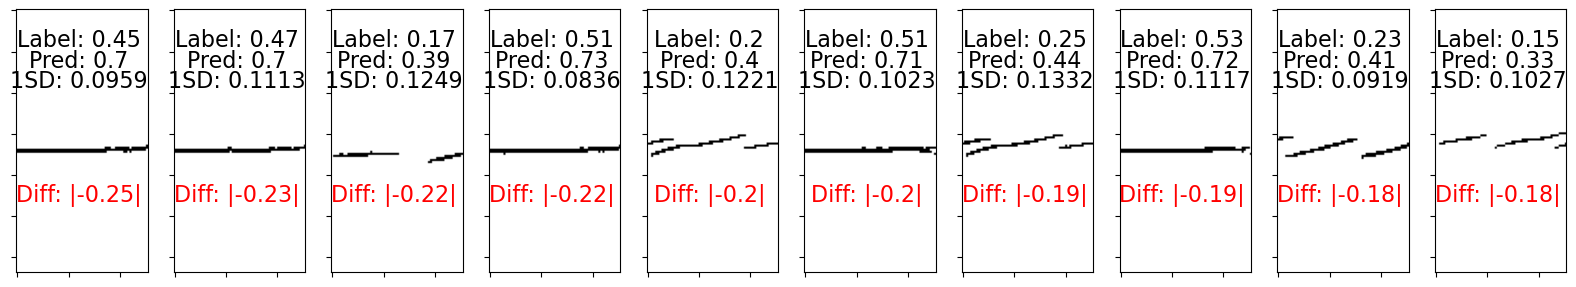

In [205]:
plotting_EXP(test_generator, test_pred, test_label, test_SD, 'test', 0, 10)

size_data_all: 5944
size_data_meetTS: 212
custom_2SD_Accuracy 96.43337819650067 %
pred_outlier:  [0.69 0.21 0.64 0.64 0.26 0.7  0.65 0.65 0.57 0.66]
truth_outlier:  [0.59 0.11 0.54 0.54 0.16 0.6  0.55 0.56 0.48 0.57]
Top_nth_Outier > 1SD:  200 - 210
E440_64px_w_CNN/0.5903_0.0838_win_09_t_043_E440_64px_w_CNN_cfuv.npy
E440_64px_w_CNN/0.5903_0
E451_64px_w_CNN/0.1054_0.1083_win_02_t_008_E451_64px_w_CNN_cfuv.npy
E451_64px_w_CNN/0.1054_0
E439_64px_w_CNN/0.5402_0.0942_win_01_t_060_E439_64px_w_CNN_cfuv.npy
E439_64px_w_CNN/0.5402_0
E440_64px_w_CNN/0.5391_0.0988_win_11_t_038_E440_64px_w_CNN_cfuv.npy
E440_64px_w_CNN/0.5391_0
E482_64px_w_CNN/0.1557_0.1072_win_04_t_009_E482_64px_w_CNN_cfuv.npy
E482_64px_w_CNN/0.1557_0
E440_64px_w_CNN/0.5960_0.0817_win_09_t_048_E440_64px_w_CNN_cfuv.npy
E440_64px_w_CNN/0.5960_0
E439_64px_w_CNN/0.5467_0.0940_win_01_t_070_E439_64px_w_CNN_cfuv.npy
E439_64px_w_CNN/0.5467_0
E439_64px_w_CNN/0.5583_0.0791_win_01_t_066_E439_64px_w_CNN_cfuv.npy
E439_64px_w_CNN/0.5583_0
E442_6

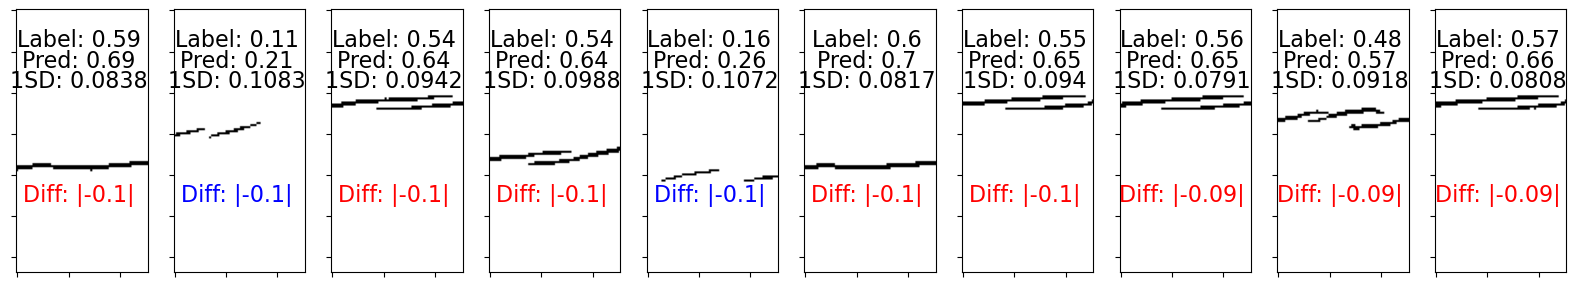

In [226]:
plotting_EXP(train_generator, train_pred, train_label, train_SD, 'train', 200, 10)

size_data_all: 1677
size_data_meetTS: 74
custom_2SD_Accuracy 95.58735837805605 %
pred_outlier:  [0.22 0.24 0.61 0.59 0.55 0.43 0.25 0.66 0.53 0.67]
truth_outlier:  [0.1  0.12 0.5  0.48 0.44 0.32 0.14 0.56 0.43 0.57]
Top_nth_Outier > 1SD:  60 - 70
E484_64px_w_CNN/0.1024_0.1146_win_04_t_014_E484_64px_w_CNN_cfuv.npy
E484_64px_w_CNN/0.1024_0
E439_64px_w_CNN/0.1153_0.1235_win_06_t_006_E439_64px_w_CNN_cfuv.npy
E439_64px_w_CNN/0.1153_0
E457_64px_w_CNN/0.4969_0.0903_win_06_t_018_E457_64px_w_CNN_cfuv.npy
E457_64px_w_CNN/0.4969_0
E457_64px_w_CNN/0.4826_0.0795_win_06_t_017_E457_64px_w_CNN_cfuv.npy
E457_64px_w_CNN/0.4826_0
E457_64px_w_CNN/0.4398_0.0874_win_06_t_016_E457_64px_w_CNN_cfuv.npy
E457_64px_w_CNN/0.4398_0
E457_64px_w_CNN/0.3221_0.0870_win_06_t_012_E457_64px_w_CNN_cfuv.npy
E457_64px_w_CNN/0.3221_0
E452_64px_w_CNN/0.1357_0.1115_win_02_t_009_E452_64px_w_CNN_cfuv.npy
E452_64px_w_CNN/0.1357_0
E442_64px_w_CNN/0.5554_0.0797_win_10_t_020_E442_64px_w_CNN_cfuv.npy
E442_64px_w_CNN/0.5554_0
E457_64px

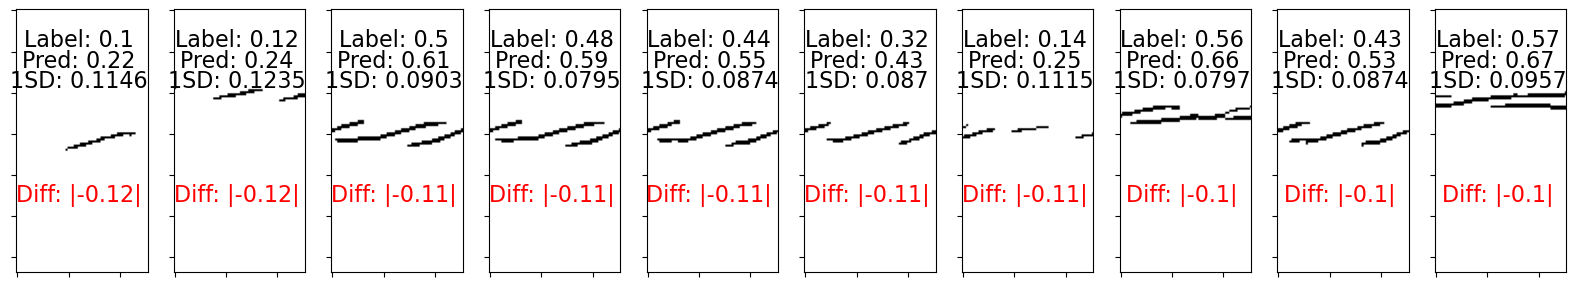

In [233]:
plotting_EXP(eval_generator, eval_pred, eval_label, eval_SD, 'eval', 60, 10)

In [ ]:
## def plotting_EXP_curl(generator, pred, label, SD, mode, top_ith, num_sample):
      ## selecting outliers 
    y= pred.flatten()
    x= label
    if len(x) == len(y):
        print('size_data_all:',len(x))
    idx = np.abs(x-y) > 2*SD
    print('size_data_meetTS:', np.sum(idx))
    print('custom_2SD_Accuracy',(1-np.sum(idx)/len(x))*100, '%' )
    
  
    pred_outlier = np.round(y[idx],2)
    truth_outlier =np.round(x[idx],2)
    diff = np.round(np.abs(pred_outlier - truth_outlier),2)

        ##indexing from large to small for outlier 
    outlier_idx = np.argsort(diff)[::-1]
    y_outlier = pred_outlier[outlier_idx]
    x_outlier = truth_outlier[outlier_idx]
    offset_outlier = np.round(x_outlier-y_outlier,2)
        ## print top rank (num_sample) by the size of errors
    print('pred_outlier: ', y_outlier[top_ith:top_ith+num_sample])
    print('truth_outlier: ', x_outlier[top_ith:top_ith+num_sample])
    
    ##creating fault map of those outliers 
    CMAP = plt.cm.seismic
    minCMAP = -0.01
    maxCMAP = 0.01
    ncols = num_sample
    print('Top_nth_Outier > 2SD: ', top_ith, '-', top_ith+ncols)
    fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=(36,8))
    norm = mpl.colors.Normalize(vmin=minCMAP, vmax=maxCMAP) 
    mappable = plt.cm.ScalarMappable(norm=norm, cmap=CMAP)
    cbar = fig.colorbar(mappable, ax = axs.ravel().tolist(), 
                    orientation='horizontal', fraction=0.05)
    cbar.ax.tick_params(axis='x', labelsize=20)
    for i in range(ncols):
        filename = generator.filenames[:len(pred)][idx][outlier_idx][top_ith:top_ith+ncols][i]
        print(filename)
        fig_title = (filename[0:24])
        print(fig_title)
        data = np.load(DATA_DIR + NPY_FOLDER + filename)
        prediction = y_outlier[top_ith:top_ith+ncols]
        label = x_outlier[top_ith:top_ith+ncols]
        offset = offset_outlier[top_ith:top_ith+ncols]
        result = np.abs(offset) < np.round(2*SD[idx][outlier_idx][top_ith:top_ith+ncols],2)
        EXP = str(filename[0:8]) + '/w'+ str(filename[22:30])
        
        axs[i].set_title(str(EXP),fontsize = 15)
        text_label = axs[i].text(30,20, 'label: ' + str(label[i]), fontsize =20,
                           ha="center", va="center")
        text_prediction = axs[i].text(30,30, 'pred: ' + str(prediction[i]), fontsize =20,
                           ha="center", va="center")
        text_diff = axs[i].text(30,40, 'diff: ' + str(offset[i]), fontsize =20,
                           ha="center", va="center")
        text_2SD = axs[i].text(30,50, '2SD: ' + str(2*SD[idx][outlier_idx][top_ith:top_ith+ncols][i]), fontsize =20,
                           ha="center", va="center")
        if result[i] == True:
            text_result = axs[i].text(30,90, 'CORRECT', fontsize =20,
                           ha="center", va="center", color="b")
            Error = axs[i].text(30,100, 'Error < 2SD', fontsize =18,
                           ha="center", va="center")
        else:
            text_result = axs[i].text(30,90, 'INCORRECT', fontsize =20,
                           ha="center", va="center", color="r")
            Error = axs[i].text(30,100, 'Error > 2SD', fontsize =18,
                           ha="center", va="center")

        axs[i].imshow(data[:, :, 0], norm=norm, aspect=1, cmap=CMAP)
        axs[i].set_xticklabels( () )
        axs[i].set_yticklabels( () )
#     plt.savefig(MODEL_DIR +'/' + str(mode) + '_outlier.png')

size_data_all: 1530
size_data_meetTS: 139
custom_2SD_Accuracy 90.91503267973856 %
pred_outlier:  [0.59 0.94 0.95 0.96 0.52 0.72 0.76 0.96 0.65 0.45]
truth_outlier:  [0.37 0.72 0.73 0.74 0.31 0.51 0.55 0.75 0.44 0.24]
Top_nth_Outier > 2SD:  20 - 30
EB_050_3/0.37_0.06_win_2_t_074_EB_050_3_cfuv.npy
EB_050_3/0.37_0.06_win_2
EB_150_2/0.72_0.06_win_1_t_133_EB_150_2_cfuv.npy
EB_150_2/0.72_0.06_win_1
EB_150_2/0.73_0.05_win_1_t_136_EB_150_2_cfuv.npy
EB_150_2/0.73_0.05_win_1
EB_150_2/0.74_0.05_win_1_t_135_EB_150_2_cfuv.npy
EB_150_2/0.74_0.05_win_1
EB_050_2/0.31_0.09_win_2_t_085_EB_050_2_cfuv.npy
EB_050_2/0.31_0.09_win_2
EB_150_2/0.51_0.09_win_1_t_102_EB_150_2_cfuv.npy
EB_150_2/0.51_0.09_win_1
EB_150_2/0.55_0.09_win_1_t_105_EB_150_2_cfuv.npy
EB_150_2/0.55_0.09_win_1
EB_150_2/0.75_0.06_win_1_t_150_EB_150_2_cfuv.npy
EB_150_2/0.75_0.06_win_1
EB_150_3/0.44_0.08_win_4_t_093_EB_150_3_cfuv.npy
EB_150_3/0.44_0.08_win_4
EB_025_3/0.24_0.08_win_1_t_063_EB_025_3_cfuv.npy
EB_025_3/0.24_0.08_win_1


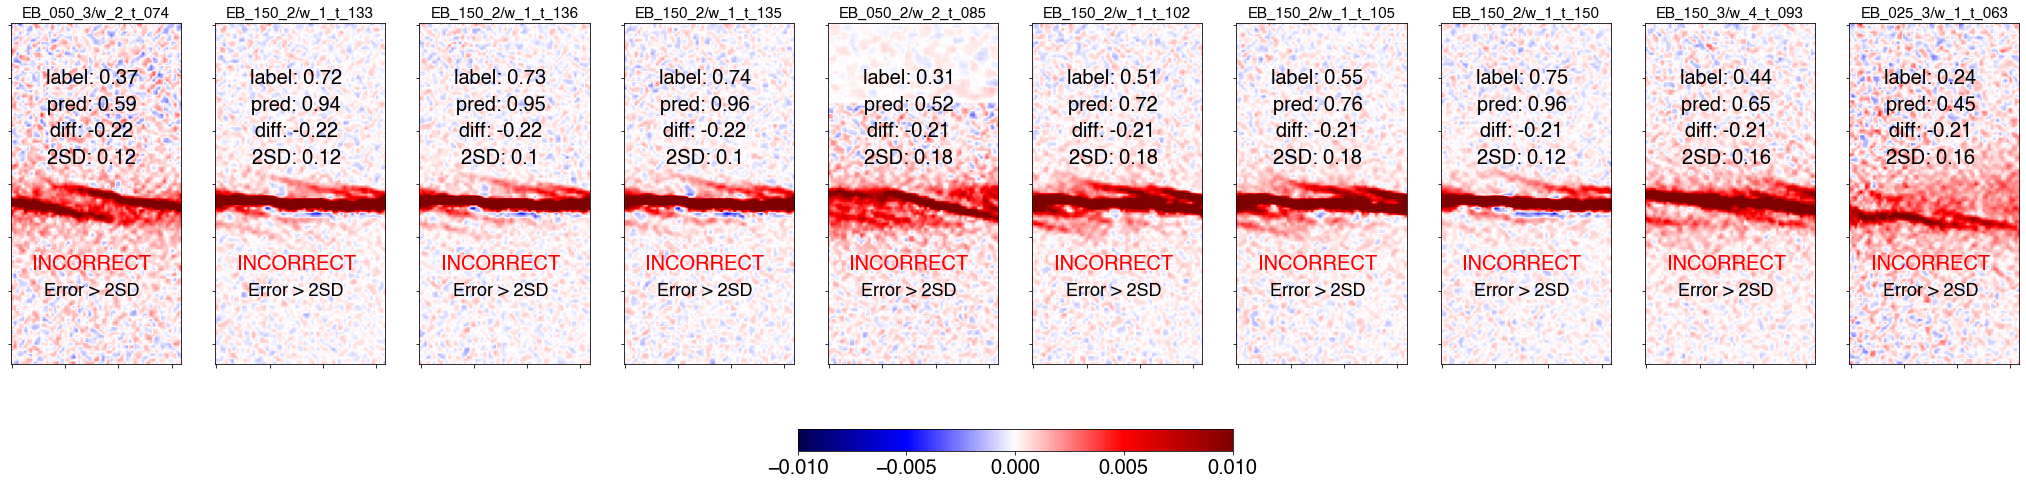

In [57]:
plotting_EXP_curl(test_generator, test_pred, test_label, test_SD, 'test', 20, 10)

size_data_all: 3067
size_data_meetTS: 119
custom_2SD_Accuracy 96.11998695793935 %
pred_outlier:  [0.03 0.67 0.18 0.49 0.56 0.48 0.71 0.53 0.54 0.62]
truth_outlier:  [0.32 0.4  0.44 0.25 0.32 0.24 0.47 0.77 0.77 0.39]
Top_nth_Outier > 2SD:  0 - 10
EB_050_2/0.32_0.12_win_0_t_081_EB_050_2_cfuv.npy
EB_050_2/0.32_0.12_win_0
EB_050_3/0.40_0.10_win_1_t_083_EB_050_3_cfuv.npy
EB_050_3/0.40_0.10_win_1
EB_025_2/0.44_0.11_win_4_t_066_EB_025_2_cfuv.npy
EB_025_2/0.44_0.11_win_4
EB_150_2/0.25_0.07_win_3_t_081_EB_150_2_cfuv.npy
EB_150_2/0.25_0.07_win_3
EB_150_2/0.32_0.06_win_3_t_085_EB_150_2_cfuv.npy
EB_150_2/0.32_0.06_win_3
EB_150_2/0.24_0.05_win_3_t_087_EB_150_2_cfuv.npy
EB_150_2/0.24_0.05_win_3
EB_150_3/0.47_0.09_win_2_t_119_EB_150_3_cfuv.npy
EB_150_3/0.47_0.09_win_2
PP_025_2/0.77_0.10_win_4_t_088_PP_025_2_cfuv.npy
PP_025_2/0.77_0.10_win_4
PP_025_2/0.77_0.09_win_4_t_090_PP_025_2_cfuv.npy
PP_025_2/0.77_0.09_win_4
EB_150_2/0.39_0.05_win_3_t_088_EB_150_2_cfuv.npy
EB_150_2/0.39_0.05_win_3


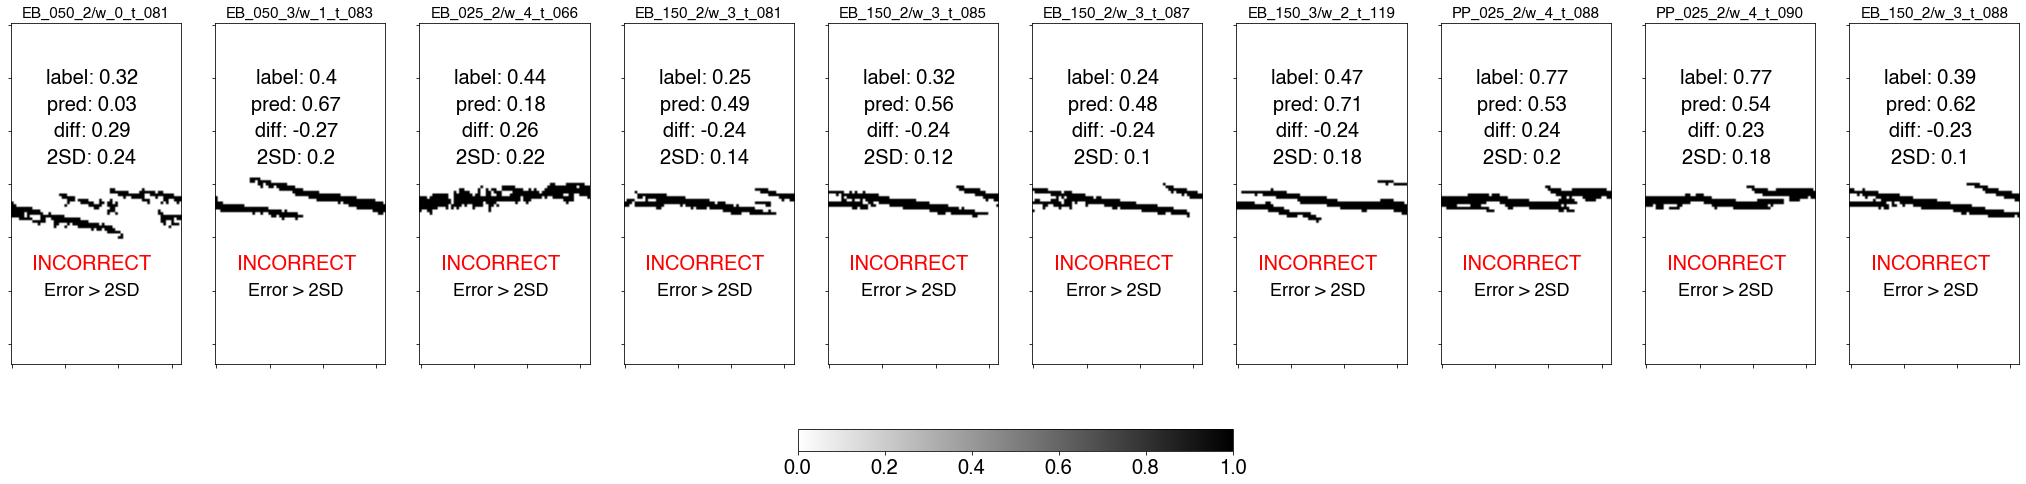

In [58]:
plotting_EXP(eval_generator, eval_pred, eval_label, eval_SD, 'eval', 0, 10)

In [244]:
def plotting_criteria_EXP(generator, pred, label, SD, mode, top_ith, num_sample):
      ## selecting outliers 
    y= pred.flatten()
    x= label
    if len(x) == len(y):
        print('size_data_all:',len(x))
#     idx = np.logical_and(np.abs(y-x) < 2*SD, x <0.55)
    idx = np.logical_and(y>0.9, y <0.99)
    print('size_data_meetTS:', np.sum(idx))
    print('%meet_criteria',(1-np.sum(idx)/len(x))*100, '%' )
    
  
    pred_outlier = np.round(y[idx],2)
    truth_outlier =np.round(x[idx],2)
    diff = np.round(np.abs(pred_outlier - truth_outlier),2)

        ##indexing from large to small for outlier 
    outlier_idx = np.argsort(diff)[::-1]
    y_outlier = pred_outlier[outlier_idx]
    x_outlier = truth_outlier[outlier_idx]
    offset_outlier = np.round(x_outlier-y_outlier,2)
        ## print top rank (num_sample) by the size of errors
    print('pred_outlier: ', y_outlier[top_ith:top_ith+num_sample])
    print('truth_outlier: ', x_outlier[top_ith:top_ith+num_sample])
    
    ##creating fault map of those outliers 
    CMAP = plt.cm.binary
    minCMAP = 0
    maxCMAP = 1
    ncols = num_sample
    print('Top_nth_Outier > 2SD: ', top_ith, '-', top_ith+ncols)
    fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=(20,10))
    norm = mpl.colors.Normalize(vmin=minCMAP, vmax=maxCMAP) 
#     mappable = plt.cm.ScalarMappable(norm=norm, cmap=CMAP)
#     cbar = fig.colorbar(mappable, ax = axs.ravel().tolist(), 
#                     orientation='horizontal', fraction=0.05)
#     cbar.ax.tick_params(axis='x', labelsize=20)      
    for i in range(ncols):
        filename = generator.filenames[:len(pred)][idx][outlier_idx][top_ith:top_ith+ncols][i]
        print(filename)
        fig_title = (filename[0:24])
        print(fig_title)
        data = np.load(DATA_DIR + NPY_FOLDER + filename)
        prediction = y_outlier[top_ith:top_ith+ncols]
        label = x_outlier[top_ith:top_ith+ncols]
        offset = offset_outlier[top_ith:top_ith+ncols]
        two_SD = 2*SD[idx][outlier_idx][top_ith:top_ith+ncols]
        result = np.abs(offset) < np.round(2*SD[idx][outlier_idx][top_ith:top_ith+ncols],2)
        EXP = str(filename[0:8]) + '/w'+ str(filename[22:30])
        
        FontSize = 30
        
        text_label = axs[i].text(30,20, 'Label: ' 
                                     + str(label[i]), 
                                     fontsize =FontSize, 
                                     ha="center", va="center")
        text_prediction = axs[i].text(30,30, 'Pred: ' + str(prediction[i]), 
                                      fontsize =FontSize,
                                       ha="center", va="center")
        text_2SD = axs[i].text(30,40, '2SD: ' + str(two_SD[i]), 
                                      fontsize =FontSize,
                                       ha="center", va="center")

        if result[i] == True:
            text_result = axs[i].text(30,90, 'Diff: |'  + str(offset[i]) + '|' , 
                                fontsize =FontSize, ha="center", 
                                      va="center", color="b")
        else:
            text_result = axs[i].text(30,90, 'Diff: |'  + str(offset[i]) + '|' ,
                                fontsize =FontSize, ha="center", 
                                      va="center", color="r")
        axs[i].imshow(data[:, :, 1], norm=norm, aspect=1, cmap=CMAP)
        axs[i].set_xticklabels( () )
        axs[i].set_yticklabels( () )

size_data_all: 1530
size_data_meetTS: 166
%meet_criteria 89.15032679738562 %
pred_outlier:  [0.95 0.91 0.95 0.9  0.95]
truth_outlier:  [0.92 0.94 0.93 0.92 0.93]
Top_nth_Outier > 2SD:  120 - 125
PP_025_2/0.92_0.06_win_3_t_131_PP_025_2_cfuv.npy
PP_025_2/0.92_0.06_win_3
PP_050_2/0.94_0.05_win_0_t_189_PP_050_2_cfuv.npy
PP_050_2/0.94_0.05_win_0
PP_050_2/0.93_0.05_win_0_t_210_PP_050_2_cfuv.npy
PP_050_2/0.93_0.05_win_0
PP_050_2/0.92_0.05_win_0_t_212_PP_050_2_cfuv.npy
PP_050_2/0.92_0.05_win_0
PP_025_2/0.93_0.06_win_3_t_140_PP_025_2_cfuv.npy
PP_025_2/0.93_0.06_win_3


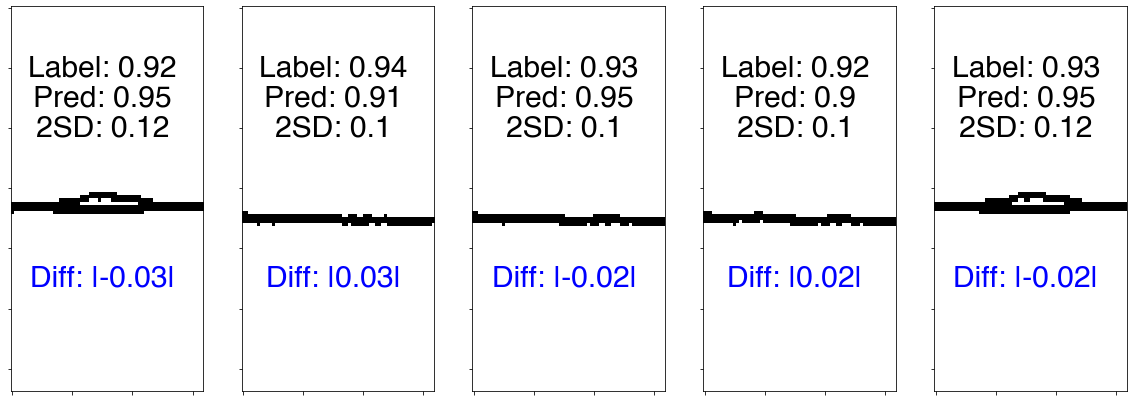

In [248]:
plotting_criteria_EXP(test_generator, test_pred, test_label, test_SD, 'test',120, 5)

# Above cells need fixing code and need to incorporate curl map

In [84]:
def create_dictionary(EXP_list): 
    EXP_Dict = {}
    for e in EXP_list:
        filename_list = np.loadtxt(DATA_DIR + F_MASTER + '/' + str(e) +'.txt',dtype='str')
        KE_label_list = np.array([float(f.split('/')[-1][0:4]) for f in filename_list])
        SD_list = np.array([float(f.split('/')[-1][5:9]) for f in filename_list])
        win_list = np.array([int(f.split('win_')[-1][0:1]) for f in filename_list])
        time_list = np.array([int(f.split('t_')[-1][0:3]) for f in filename_list])
        sliced_npy_List =[]
        for i in range(len(filename_list)):
            sliced_npy_dict = {'fn':filename_list[i], 'KE':KE_label_list[i],
                              'SD': SD_list[i],'w': win_list[i], 't': time_list[i]}
            sliced_npy_List.append(sliced_npy_dict)
        combo = np.vstack((KE_label_list,SD_list,win_list,time_list))
        sliced_npy_List.append(combo)
        EXP_Dict[str(e)] = sliced_npy_List        
    return EXP_Dict

In [85]:
EP_EXP_LIST = ['EB_025_1','EB_025_2','EB_025_3',
           'EB_050_1','EB_050_2','EB_050_3',
           'EB_150_1','EB_150_2','EB_150_3',
           'PP_025_1','PP_025_2',
           'PP_050_1','PP_050_2',
           'PP_100_1','PP_100_2',
           'PP_150_1']

In [86]:
EXP_Dict = create_dictionary(EP_EXP_LIST)
EXP_to_plot = 'EB_150_2'
time_to_plot = 70
print('len_of_Dict:', len(EXP_Dict[EXP_to_plot]))

len_of_Dict: 676


In [90]:
#manual user pick slide
#Plot Tool for a specific Experiment Time Slice, which will show full ROI
#Must run previous cell to obtain 'ltp_limit'
#Pick index s from the order of selected slices that fit the criteria for KE_label 

def label_slice_by_time(EXP_Dict, EXP_to_plot, time_to_plot):
    label_slice_view = []
    blind_test_list = []
    for slice_sample in EXP_Dict[str(EXP_to_plot)][0:-1]:
        if slice_sample['t'] == time_to_plot:
            label_slice_view.append(slice_sample)
            blind_test_list.append(slice_sample['fn'])
            blind_test_path = DATA_DIR + ML_EXP + 'blind_test_master_'+str(EXP_to_plot) +'_' + str(time_to_plot)+ '.txt'
            np.savetxt(blind_test_path, blind_test_list, fmt="%s")
    return label_slice_view                                       

def blind_pred(EXP_to_plot, time_to_plot):
    blind_master = 'blind_test_master_'+str(EXP_to_plot) +'_' + str(time_to_plot)+ '.txt' 
    blind_test_generator = EvalTestGenerator(ML_EXP, NPY_FOLDER, blind_master, 
                                   batch_size = 1, 
                                   data_dir=DATA_DIR, shuffle = False)
    # print(blind_test_generator[2][1][0][0])
    pred = best_model.predict(x=blind_test_generator)
    blind_pred = (np.round(np.hstack(pred.flatten()),2))
    return blind_pred
                                  
def plot_curl(label_slice_view, EXP_to_plot, time_to_plot):
    ncols = 5
    #plotting fault map from selected time slice for the whole ROI (w_0,w_1,w_2,w_3,w_4)
    
    CMAP = plt.cm.seismic
    minCMAP = -0.02
    maxCMAP = 0.02
    fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=(16,6))
    norm = mpl.colors.Normalize(vmin=minCMAP, vmax=maxCMAP) 
    mappable = plt.cm.ScalarMappable(norm=norm, cmap=CMAP)
    fig.colorbar(mappable, ax = axs.ravel().tolist(), fraction=.015)
    fig.suptitle('EXP: ' + str(EXP_to_plot),fontsize = 20)
    axs[0].set_ylabel('Time: ' + str(time_to_plot),fontsize = 20)
    
    Pred = blind_pred(EXP_to_plot, time_to_plot)
    
    for i in range(ncols):
        filename = label_slice_view[i]['fn']
        KE = float(filename.split('/')[-1][0:4])
        data = np.load(DATA_DIR + NPY_FOLDER + filename)
#         axs[i].set_title('KE = ' + str(KE),fontsize = 15)
        text_label = axs[i].text(30,30, 'Label: ' + str(KE), fontsize =15,
                                 ha="center", va="center")
        text_pred = axs[i].text(30,40, 'Pred: ' + str(Pred[i]), fontsize =15,
                           ha="center", va="center")
        axs[i].imshow(data[:, :, 0],norm=norm, aspect=1, cmap=CMAP)
        axs[i].set_xticklabels( () )
        axs[i].set_yticklabels( () )

def plot_fault_map(label_slice_view, EXP_to_plot, time_to_plot):
    ncols = 5
    CMAP = plt.cm.binary
    minCMAP = 0
    maxCMAP = 1
    fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=(16,6))
    norm = mpl.colors.Normalize(vmin=minCMAP, vmax=maxCMAP) 
    mappable = plt.cm.ScalarMappable(norm=norm, cmap=CMAP)
    fig.colorbar(mappable, ax = axs.ravel().tolist(), fraction=.015)
    fig.suptitle('EXP: ' + str(EXP_to_plot),fontsize = 20)
    axs[0].set_ylabel('Time: ' + str(time_to_plot),fontsize = 20)
    
    Pred = blind_pred(EXP_to_plot, time_to_plot)
    print('average_pred:', np.average(Pred))
    print(Pred)
    
    for i in range(ncols):
        filename = label_slice_view[i]['fn']
        KE = float(filename.split('/')[-1][0:4])
        Preds = Pred[i]
        Diff = np.abs(KE-Preds)
        SD = float(filename.split('/')[-1][5:9])
        result = np.abs(Diff) < 2*SD
        print(result)
        
        data = np.load(DATA_DIR + NPY_FOLDER + filename)
         
        text_label = axs[i].text(30,20, 'Label: ' + str(KE), fontsize =15,
                                 ha="center", va="center")
        text_pred = axs[i].text(30,30, 'Pred: ' + str(Preds), fontsize =15,
                           ha="center", va="center")
        text_diff = axs[i].text(30,40, 'Diff: ' + str(np.round(np.abs(Preds-KE),2)), fontsize =15,
                                 ha="center", va="center")
        text_2SD = axs[i].text(30,50, '2SD: ' + str(2*SD), fontsize =15,
                                 ha="center", va="center")
        
        if result == True:
            text_result = axs[i].text(30,90, 'CORRECT', fontsize =20,
                           ha="center", va="center", color="b")
            Error = axs[i].text(30,100, 'Error < 2SD', fontsize =18,
                           ha="center", va="center")
        else:
            text_result = axs[i].text(30,90, 'INCORRECT', fontsize =20,
                           ha="center", va="center", color="r")
            Error = axs[i].text(30,100, 'Error > 2SD', fontsize =18,
                           ha="center", va="center")
            
        axs[i].imshow(data[:, :, 1],norm=norm, aspect=1, cmap=CMAP)
        axs[i].set_xticklabels( () )
        axs[i].set_yticklabels( () )

def plot_AOI_by_time(EXP_Dict, EXP_to_plot, time_to_plot):
    label_slice_view = label_slice_by_time(EXP_Dict, EXP_to_plot, time_to_plot)
    plot_curl(label_slice_view, EXP_to_plot, time_to_plot)
    plot_fault_map(label_slice_view, EXP_to_plot, time_to_plot)

5
5
5
5
average_pred: 0.584
[0.67 0.63 0.55 0.48 0.59]
True
True
True
True
True


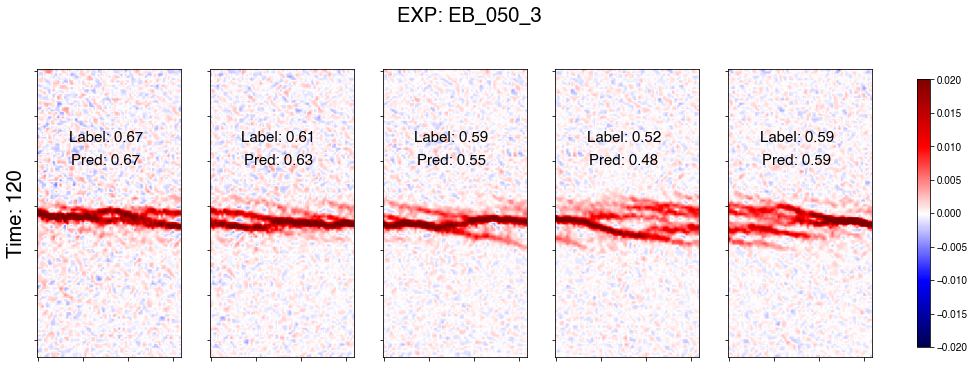

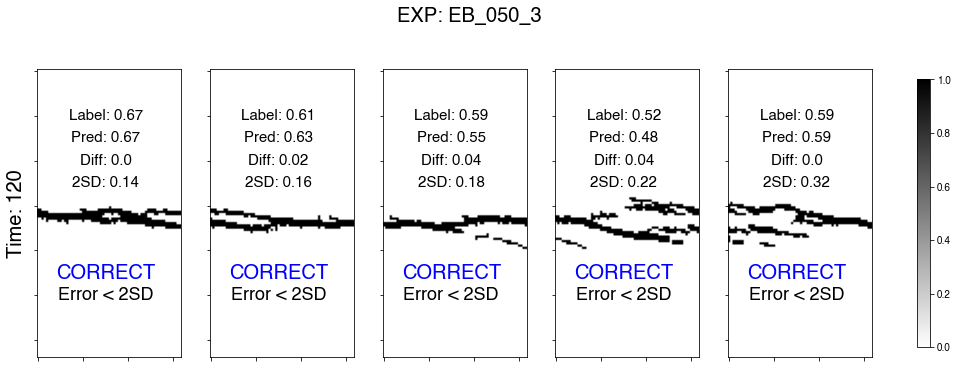

In [91]:
EXP_Dict = create_dictionary(EP_EXP_LIST)
EXP_to_plot = 'EB_050_3'
time_to_plot = 120
label_slice_by_time(EXP_Dict, EXP_to_plot, time_to_plot)
plot_AOI_by_time(EXP_Dict, EXP_to_plot, time_to_plot)

In [99]:
def plot_fault_map_simple(label_slice_view, EXP_to_plot, time_to_plot):
    ncols = 5
    CMAP = plt.cm.binary
    minCMAP = 0
    maxCMAP = 1
    fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=(16,6))
    norm = mpl.colors.Normalize(vmin=minCMAP, vmax=maxCMAP) 
    mappable = plt.cm.ScalarMappable(norm=norm, cmap=CMAP)
    
    Pred = blind_pred(EXP_to_plot, time_to_plot)
    print('average_pred:', np.average(Pred))
    print(Pred)
    
    
    for i in range(ncols):
        filename = label_slice_view[i]['fn']
        KE = float(filename.split('/')[-1][0:4])
        Preds = Pred[i]
        Diff = np.abs(KE-Preds)
        SD = float(filename.split('/')[-1][5:9])
        result = np.abs(Diff) < 2*SD
        print(result)
        
        data = np.load(DATA_DIR + NPY_FOLDER + filename)
            
        axs[i].imshow(data[:, :, 1],norm=norm, aspect=1, cmap=CMAP)
        axs[i].set_xticklabels( () )
        axs[i].set_yticklabels( () )
    plt.savefig('exp_panel.svg', dpi=900, edgecolor='w',
        orientation='portrait', format='svg',
        transparent=False, bbox_inches=None, pad_inches=0.1)

5
5
average_pred: 0.54399997
[0.6  0.44 0.61 0.49 0.58]
True
True
True
True
True


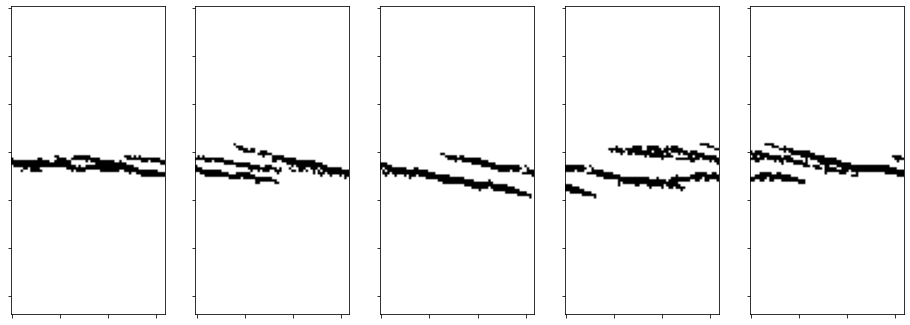

In [100]:
EXP_Dict = create_dictionary(EP_EXP_LIST)
EXP_to_plot = 'EB_050_3'
time_to_plot = 100
label_slice_view = label_slice_by_time(EXP_Dict, EXP_to_plot, time_to_plot)
plot_fault_map_simple(label_slice_view, EXP_to_plot, time_to_plot)


In [ ]:
#manual user pick slide
#Plot Tool for a specific Experiment Time Slice, which will show full ROI
#Must run previous cell to obtain 'ltp_limit'
#Pick index s from the order of selected slices that fit the criteria for KE_label 

def label_slice_by_time(EXP_Dict, EXP_to_plot, time_list):
    label_slice_view = []
    blind_test_list = []
    for time_to_plot in time_list:
        for slice_sample in EXP_Dict[str(EXP_to_plot)][0:-1]:
            if slice_sample['t'] == time_to_plot:
                label_slice_view.append(slice_sample)
                blind_test_list.append(slice_sample['fn'])
        blind_test_path = ML_EXP + 'blind_test_master_'+str(EXP_to_plot) +'_' + str(time_to_plot)+ '.txt'
        np.savetxt(blind_test_path, blind_test_list, fmt="%s")
    return label_slice_view                                       

def blind_pred(EXP_to_plot, time_list):
    blind_pred_list = []
    for time_to_plot in time_list:
        blind_master = 'blind_test_master_'+str(EXP_to_plot) +'_' + str(time_to_plot)+ '.txt' 
        blind_test_generator = EvalTestGenerator(ML_EXP, NPY_FOLDER, blind_master, 
                                       batch_size = 1, 
                                       data_dir=DATA_DIR, shuffle = False)
        # print(blind_test_generator[2][1][0][0])
        pred = best_model.predict(x=blind_test_generator)
        blind_pred = (np.round(np.hstack(pred.flatten()),2))
        blind_pred_list.append(blind_pred)
    return blind_pred_list
                                  
def plot_blind_test(label_slice_view, EXP_to_plot, time_to_plot):
    ncols = 5
    #plotting fault map from selected time slice for the whole ROI (w_0,w_1,w_2,w_3,w_4)
    
    CMAP = plt.cm.seismic
    minCMAP = -0.02
    maxCMAP = 0.02
    fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=(16,6))
    norm = mpl.colors.Normalize(vmin=minCMAP, vmax=maxCMAP) 
    mappable = plt.cm.ScalarMappable(norm=norm, cmap=CMAP)
    fig.colorbar(mappable, ax = axs.ravel().tolist(), fraction=.015)
    fig.suptitle('EXP: ' + str(exp_to_plot),fontsize = 20)
    axs[0].set_ylabel('Time: ' + str(time_to_plot),fontsize = 20)
    Pred = blind_pred(EXP_to_plot, time_to_plot)
    for i in range(ncols):
        filename = label_slice_view[i]['fn']
        KE = float(filename.split('/')[-1][0:4])
        data = np.load(DATA_DIR + 'slice_npy_SD/' + filename)
#         axs[i].set_title('KE = ' + str(KE),fontsize = 15)
        text_label = axs[i].text(30,30, 'Label: ' + str(KE), fontsize =15,
                                 ha="center", va="center")
        text_pred = axs[i].text(30,40, 'Pred: ' + str(Pred[i]), fontsize =15,
                           ha="center", va="center")
        axs[i].imshow(data[:, :, 0],norm=norm, aspect=1, cmap=CMAP)
        axs[i].set_xticklabels( () )
        axs[i].set_yticklabels( () )

def plot_fault_map(label_slice_view, EXP_to_plot, time_to_plot):
    ncols = 5
    CMAP = plt.cm.binary
    minCMAP = 0
    maxCMAP = 1
    fig, axs = plt.subplots(nrows=1, ncols=ncols, figsize=(16,6))
    norm = mpl.colors.Normalize(vmin=minCMAP, vmax=maxCMAP) 
    mappable = plt.cm.ScalarMappable(norm=norm, cmap=CMAP)
    fig.colorbar(mappable, ax = axs.ravel().tolist(), fraction=.015)
    fig.suptitle('EXP: ' + str(exp_to_plot),fontsize = 20)
    axs[0].set_ylabel('Time: ' + str(time_to_plot),fontsize = 20)
    Pred = blind_pred(EXP_to_plot, time_to_plot)
    print('average_pred:', np.average(Pred))
    for i in range(ncols):
        filename = label_slice_view[i]['fn']
        KE = float(filename.split('/')[-1][0:4])
#         Pred = Pred[i]
#         Diff = np.abs(KE-Pred)
        SD = float(filename.split('/')[-1][5:9])*2
        data = np.load(DATA_DIR + 'slice_npy_SD/' + filename)
        
        text_label = axs[i].text(30,20, 'Label: ' + str(KE), fontsize =15,
                                 ha="center", va="center")
        text_pred = axs[i].text(30,30, 'Pred: ' + str(Pred[i]), fontsize =15,
                           ha="center", va="center")
        text_diff = axs[i].text(30,40, 'Diff: ' + str(np.round(np.abs(Pred[i]-KE),2)), fontsize =15,
                                 ha="center", va="center")
        text_2SD = axs[i].text(30,50, '2SD: ' + str(SD), fontsize =15,
                                 ha="center", va="center")
        axs[i].imshow(data[:, :, 1],norm=norm, aspect=1, cmap=CMAP)
        axs[i].set_xticklabels( () )
        axs[i].set_yticklabels( () )

def plot_AOI_by_time(EXP_Dict, EXP_to_plot, time_to_plot):
    label_slice_view = label_slice_by_time(EXP_Dict, EXP_to_plot, time_to_plot)
    plot_KE(label_slice_view, EXP_to_plot, time_to_plot)
    plot_fault_map(label_slice_view, EXP_to_plot, time_to_plot)

In [ ]:
def plotting_with_TS_H(generator_LSP, mode, EXP, selected_EP):
    ## make cross plot between prediction and label with highlighted color for subset that meet threashold
    
    fig, axs = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(15, 5))

    for g, m, ax in zip(generator_LSP, mode, axs): 
        label = g[0]
        SD = g[1]
        pred = g[2].flatten()
        if len(pred) == len(label):
            print(len(pred))
        idx = np.abs(pred-label) > 2*SD
        error_pct = np.round(100*np.sum(idx)/len(pred), 2)
        

        ax.plot(pred, label,'o', label=f'Correct')
        ax.plot(pred[idx], label[idx], 'ro', label=f'Incorrect')
        ax.plot([0, 1], [0, 1], 'k', alpha=0.2)
        ax.set_title(str(m), fontsize = 24)
        text_error = '% error (>2SD) = ' +str(error_pct) + '%'
        ax.text(0.7, 0.1, text_error, fontsize = 12,
                horizontalalignment = 'center', transform=ax.transAxes)
        ax.legend(loc='best')
        ax.set_xlabel('Truth', fontsize =18)
    axs[0].set_ylabel('Prediction', fontsize = 18)

    plt.tight_layout()
    plt.show